In [1]:
import random
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                 download=False, 
                                 transform=transform, 
                                 train=True)

test_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                download=False, 
                                transform=transform, 
                                train=False)

random.seed(42)  
train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)  
attack_loader = DataLoader(attack_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Original training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Attack samples: {len(attack_data)}")
print(f"Testing samples: {len(test_dataset)}")

Original training samples: 50000
Training samples after split: 45000
Attack samples: 5000
Testing samples: 10000


In [2]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [3]:
import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/Resnet/ResCifarBase.mod', weights_only=False, map_location="cuda")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


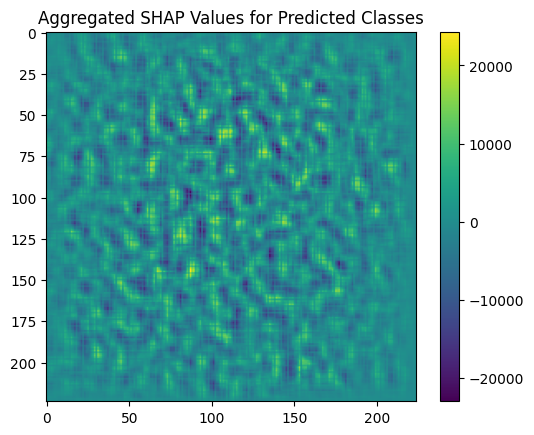

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load SHAP values
file_path = '/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Resnet/ShapCifar.npy'
shap_values = np.load(file_path)  # Shape: (3, 224, 224, 10)


device = 'cuda'
model.eval()

# Initialize aggregated SHAP array
aggregated_shap_image = np.zeros((224, 224))

# Iterate through the attack_loader to compute predicted classes
for batch_images, _ in attack_loader:
    batch_images = batch_images.to(device)

    # Get model predictions
    outputs = model(batch_images)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (batch_size,)

    # Compute SHAP values for each image
    for i, predicted_class in enumerate(predicted_classes):
        # Aggregate SHAP values for the predicted class (sum over channels)
        class_shap_values = np.sum(shap_values[:, :, :, predicted_class], axis=0)  # Shape: (224, 224)
        aggregated_shap_image += class_shap_values

# Visualize the aggregated SHAP image
plt.imshow(aggregated_shap_image, cmap="viridis")
plt.title("Aggregated SHAP Values for Predicted Classes")
plt.colorbar()
plt.show()


In [5]:
# Flatten the array and find the indices of the top 22 values
flattened = aggregated_shap_image.flatten()
top_22_indices = np.argsort(flattened)[-22:][::-1]  # Indices of top 22 values, sorted descending

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_shap_image.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixels and their SHAP values
print("Top 22 Pixels and Their SHAP Values:")
for coord in top_22_coords:
    pixel_value = aggregated_shap_image[coord]
    print(f"Pixel {coord}: SHAP Value {pixel_value:.4f}")


Top 22 Pixels and Their SHAP Values:
Pixel (np.int64(145), np.int64(87)): SHAP Value 24327.4429
Pixel (np.int64(144), np.int64(87)): SHAP Value 23958.4988
Pixel (np.int64(143), np.int64(87)): SHAP Value 21474.3681
Pixel (np.int64(73), np.int64(131)): SHAP Value 20859.0262
Pixel (np.int64(63), np.int64(105)): SHAP Value 20440.7181
Pixel (np.int64(123), np.int64(81)): SHAP Value 20385.7590
Pixel (np.int64(61), np.int64(107)): SHAP Value 19929.5081
Pixel (np.int64(124), np.int64(81)): SHAP Value 19865.9763
Pixel (np.int64(64), np.int64(105)): SHAP Value 19844.9499
Pixel (np.int64(73), np.int64(132)): SHAP Value 19785.1456
Pixel (np.int64(147), np.int64(87)): SHAP Value 19770.7076
Pixel (np.int64(144), np.int64(89)): SHAP Value 19617.8422
Pixel (np.int64(60), np.int64(111)): SHAP Value 19577.6635
Pixel (np.int64(73), np.int64(133)): SHAP Value 19571.0593
Pixel (np.int64(113), np.int64(103)): SHAP Value 19380.4403
Pixel (np.int64(115), np.int64(101)): SHAP Value 19311.7096
Pixel (np.int64(6

In [6]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ResnetCif/"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (from your output)
top_22_coords = [
    (145, 87), (144, 87), (143, 87), (73, 131), (63, 105),
    (123, 81), (61, 107), (124, 81), (64, 105), (73, 132),
    (147, 87), (144, 89), (60, 111), (73, 133), (113, 103),
    (115, 101), (63, 107), (61, 111), (115, 143), (145, 89),
    (124, 83), (145, 67)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

# Iterate through attack_loader and modify each image
for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone()  # Clone to avoid modifying the original dataset

    for img_idx, image_tensor in enumerate(batch_images):
        # Replace top pixel locations with black (0 value for all channels)
        for x, y in top_22_coords:
            image_tensor[:, x, y] = 0  # Set RGB channels to 0 at the specified location

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * len(batch_images) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")

Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40
Processed batch 40/40
Modified images saved to /home/j597s263/scratch/j597s263/Datasets/Attack/ResnetCif/
